<a href="https://colab.research.google.com/github/onolab-tmu/audio-processing-100-knocks/blob/master/lesson7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lesson 7: Chainerに基づく深層学習
===============================

* チュートリアル：https://tutorials.chainer.org/ja/tutorial.html
* ドキュメンテーション：https://docs.chainer.org/en/stable/

GPUを是非使いましょう！ (`Runtime` > `Change runtime type` > `Hardware` `accelerator` > `GPU`)

In [5]:
import chainer
chainer.print_runtime_info()

Platform: Linux-4.14.137+-x86_64-with-Ubuntu-18.04-bionic
Chainer: 6.5.0
ChainerX: Not Available
NumPy: 1.17.5
CuPy:
  CuPy Version          : 6.5.0
  CUDA Root             : /usr/local/cuda
  CUDA Build Version    : 10010
  CUDA Driver Version   : 10010
  CUDA Runtime Version  : 10010
  cuDNN Build Version   : 7603
  cuDNN Version         : 7603
  NCCL Build Version    : 2402
  NCCL Runtime Version  : 2402
iDeep: 2.0.0.post3


In [0]:
import chainer
import chainer.functions as F
import chainer.links as L
from chainer import training
from chainer.training import extensions

import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#matplotlib.use('Agg')

from IPython.display import Image

In [7]:
# Load the MNIST dataset
train, test = chainer.datasets.get_mnist()
print("Number of training examples:", len(train))
print("Number of test examples:", len(test))

Number of training examples: 60000
Number of test examples: 10000


In [0]:
def show_digit(example):
  w = int(np.sqrt(example[0].shape[0]))
  assert w * w == example[0].shape[0], "not a square image"
  plt.imshow(example[0].reshape(w, w), cmap="Greys")
  plt.title(f"label {example[1]}")

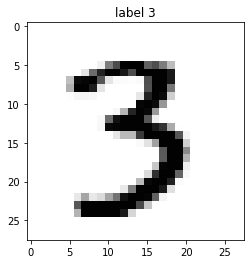

In [9]:
show_digit(train[10000])

In [0]:
# Network definition
class MLP(chainer.Chain):

    def __init__(self, n_units, n_out):
        super(MLP, self).__init__()
        with self.init_scope():
            # the size of the inputs to each layer will be inferred
            self.l1 = L.Linear(None, n_units)  # n_in -> n_units
            self.l2 = L.Linear(None, n_units)  # n_units -> n_units
            self.l3 = L.Linear(None, n_out)  # n_units -> n_out

    def forward(self, x):
        h1 = F.relu(self.l1(x))
        h2 = F.relu(self.l2(h1))
        return self.l3(h2)

In [0]:
# gpu device
device = chainer.get_device(0)

# number of units in hidden layers
unit = 1000

# mini-batch size (i.e. number of examples used in update)
batchsize = 100

# number of epochs (i.e. cycles over the dataset)
epoch = 20

# directory to output the results
out = "results"

In [0]:
# Set up a neural network to train
# Classifier reports softmax cross entropy loss and accuracy at every
# iteration, which will be used by the PrintReport extension below.
mlp_model = MLP(unit, 10)
model = L.Classifier(mlp_model)
model.to_device(device)
device.use()

In [49]:
# Setup an optimizer
optimizer = chainer.optimizers.Adam()
optimizer.setup(model)

In [0]:
# Wrap the data in iterators
train_iter = chainer.iterators.SerialIterator(train, batchsize)
test_iter = chainer.iterators.SerialIterator(test, batchsize,
                                             repeat=False, shuffle=False)

In [0]:
# Set up a trainer
updater = training.updaters.StandardUpdater(
    train_iter, optimizer, device=device)
trainer = training.Trainer(updater, (epoch, 'epoch'), out=out)

# Evaluate the model with the test dataset for each epoch
trainer.extend(extensions.Evaluator(test_iter, model, device=device))
trainer.extend(extensions.DumpGraph('main/loss'))

# Take a snapshot for each specified epoch
frequency = epoch
# Take a snapshot each ``frequency`` epoch, delete old stale
# snapshots and automatically load from snapshot files if any
# files are already resident at result directory.
trainer.extend(extensions.snapshot(n_retains=1, autoload=True),
                trigger=(frequency, 'epoch'))

# Write a log of evaluation statistics for each epoch
trainer.extend(extensions.LogReport())

# Save two plot images to the result dir
trainer.extend(
    extensions.PlotReport(['main/loss', 'validation/main/loss'],
                          'epoch', file_name='loss.png'))
trainer.extend(
    extensions.PlotReport(
        ['main/accuracy', 'validation/main/accuracy'],
        'epoch', file_name='accuracy.png'))

# Print selected entries of the log to stdout
# Here "main" refers to the target link of the "main" optimizer again, and
# "validation" refers to the default name of the Evaluator extension.
# Entries other than 'epoch' are reported by the Classifier link, called by
# either the updater or the evaluator.
trainer.extend(extensions.PrintReport(
    ['epoch', 'main/loss', 'validation/main/loss',
      'main/accuracy', 'validation/main/accuracy', 'elapsed_time']))

# Print a progress bar to stdout
trainer.extend(extensions.ProgressBar())

In [52]:
# Run the training
trainer.run()

In [53]:
!ls results

accuracy.png  cg.dot  cg.png  log  loss.png  snapshot_iter_12000


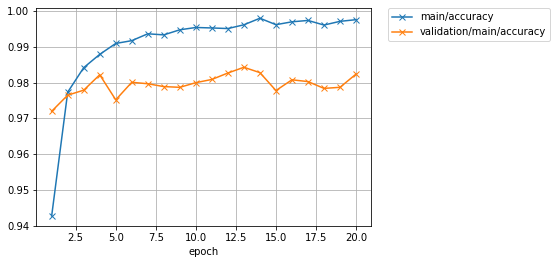

In [54]:
Image('results/accuracy.png')

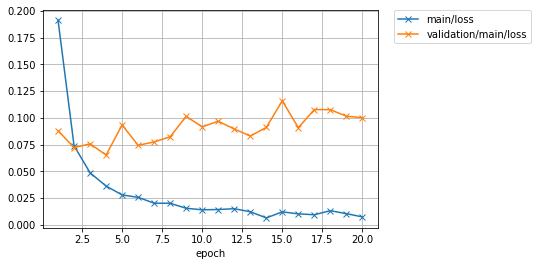

In [55]:
Image('results/loss.png')

In [0]:
def inference(example):
  x, answer = example
  x = device.send(x)
  with chainer.using_config('train', False):
      prediction = mlp_model(x[None, ...])[0].array.argmax()

  show_digit(example)
  print('Prediction:', prediction)
  print('Answer:', answer)

Prediction: 0
Answer: 0


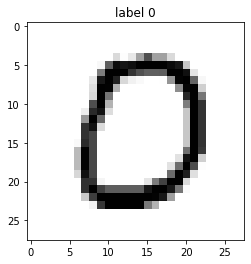

In [61]:
inference(test[10])